In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks', color_codes=True, font_scale=0.8)

import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm

import matplotlib as mpl

%matplotlib inline

Here we look at molecules with identical fragment decompositions, and then look at inter-group variance

In [3]:
ysi = pd.read_csv('ysi.csv').set_index('SMILES')
fragments = pd.read_csv('fragments.csv', index_col=0)

we use a hash function just to make grouping easier.

In [4]:
import hashlib

duplicated_frags = fragments[fragments.duplicated(keep=False)]
mol_hashes = duplicated_frags.apply(lambda x: hashlib.md5(np.array(x)).hexdigest(), 1)

duplicated_mols = ysi.loc[duplicated_frags.index].copy()
duplicated_mols['hash'] = mol_hashes

duplicated_mols['scaled_ysi'] = duplicated_mols.groupby('hash').YSI.transform(lambda x: x/x.mean())
n_groups = len(duplicated_mols.hash.unique())

hash_group = dict(zip(duplicated_mols.groupby('hash').scaled_ysi.apply(
    lambda x: x.max() - x.min()).sort_values().index, range(n_groups)))
duplicated_mols['group'] = duplicated_mols.hash.apply(lambda x: hash_group[x])

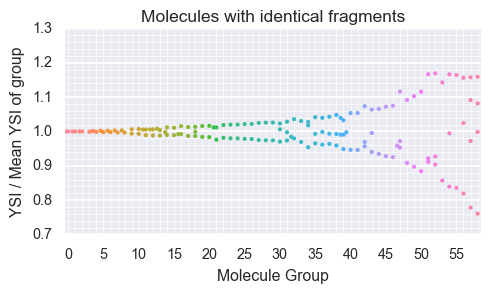

In [5]:
with sns.axes_style('darkgrid'):
    fig = plt.figure(figsize=(5,3))
    ax = fig.add_subplot(111)

sns.swarmplot(data=duplicated_mols, x='group', y='scaled_ysi', size=3)
# ax.axhline(1, ls=':', color='0.8', lw=1)
ax.set_ylim([0.7, 1.3])

ax.set_xticks(np.arange(0, n_groups, 5))
ax.set_xticklabels(np.arange(0, n_groups, 5))

ax.set_ylabel('YSI / Mean YSI of group')
ax.set_xlabel('Molecule Group')

ax.set_title('Molecules with identical fragments')

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=0.5, axis='x')
ax.grid(b=True, which='minor', color='w', linewidth=0.5,)

sns.despine()
fig.tight_layout()

fig.savefig('figures/identical_fragments.svg')

# ax.set_yscale('log')
# ax.set_ylim([10, 2000])

In [6]:
duplicated_mols.drop('hash', 1).sort_values(by='group').to_csv('data/duplicated_fragments.csv')